# Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import xgboost as xgb

# Вспомогательные функции для рисования

In [2]:
def plot_booking_status_distribution(df):
    plt.figure()
    sns.countplot(x='booking_status', data=df)
    plt.title('Distribution of Booking Status')
    plt.show()

In [3]:
def plot_correlation_matrix(df):
    corr = df.corr()
    np.fill_diagonal(corr.values, np.nan)
    plt.figure(figsize=(10, 8))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)    
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, center=0, mask=np.isnan(corr))
    plt.title('Correlation Matrix')
    plt.show()

In [4]:
def plot_one_distribution(df, name):
    plt.figure()
    sns.histplot(df[name], kde=True)
    plt.title(name)
    plt.show()

In [5]:
def plot_roc_curve(y_test, y_prob):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random classifier performance")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
df = pd.read_csv('data.csv')
print(df.shape)

(42100, 19)


# Взглянем на данные
## Соотношение классов в датасете

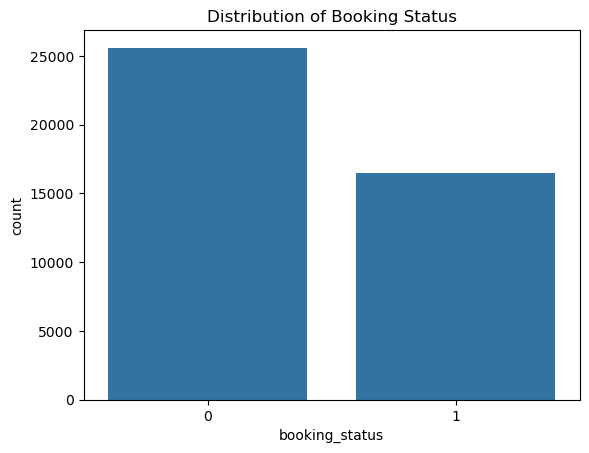

In [7]:
plot_booking_status_distribution(df)

## Матрица корреляций

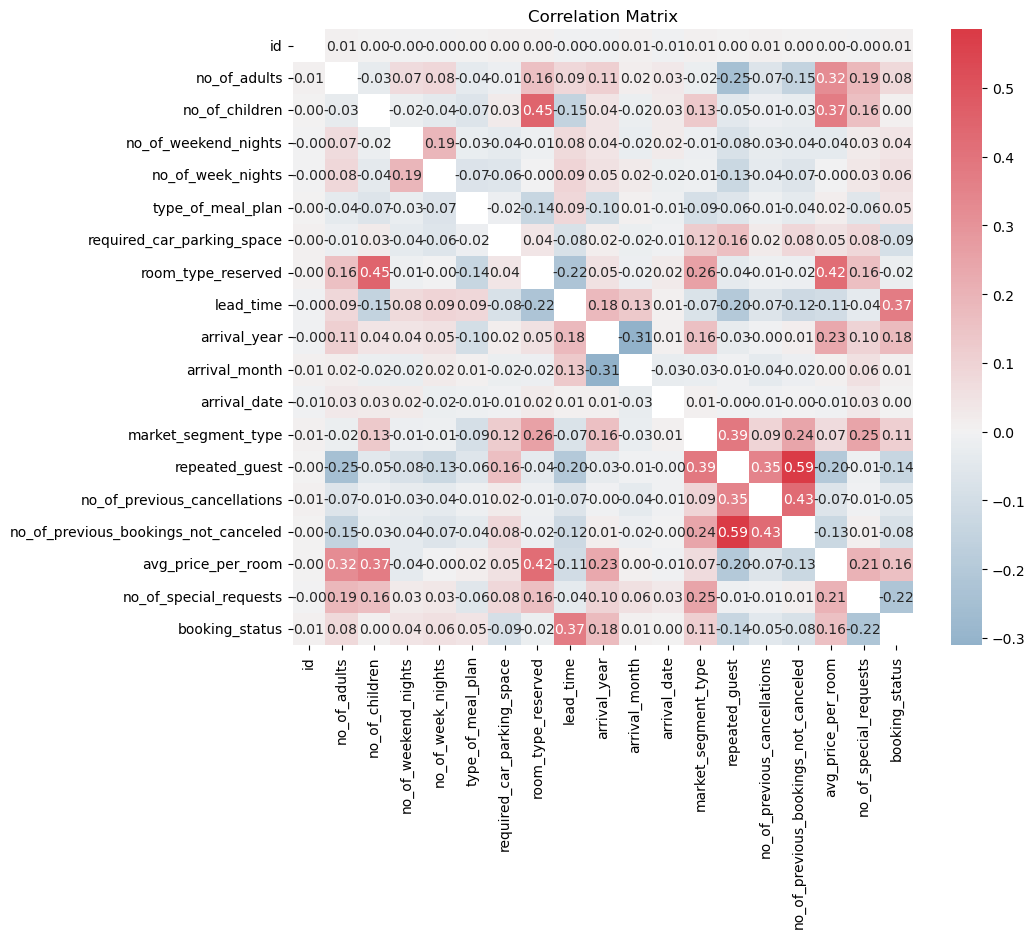

In [8]:
plot_correlation_matrix(df)

## Распределение по ценам на бронируемую комнату

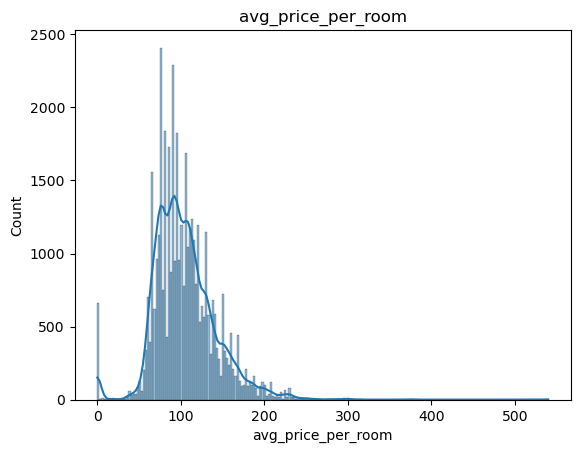

In [9]:
plot_one_distribution(df, "avg_price_per_room")

## Числа месяца прибытия

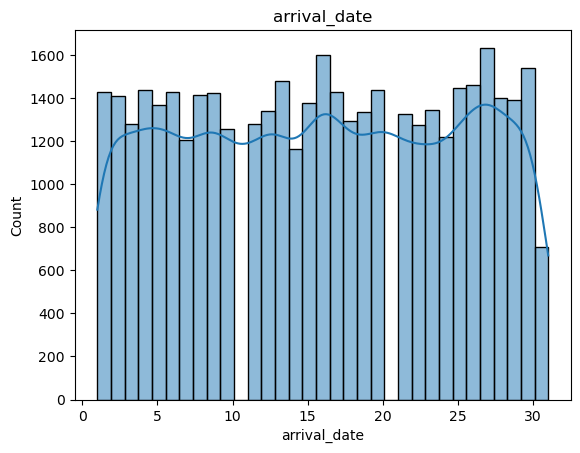

In [10]:
plot_one_distribution(df, "arrival_date")

## Месяц бронирования

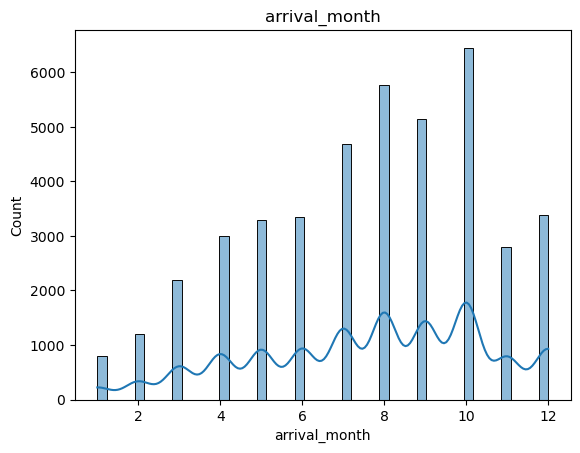

In [11]:
plot_one_distribution(df, "arrival_month")

In [12]:
categorical_names = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
quantative_names = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'avg_price_per_room']

# One-hot для категориальных переменных
df_encoded = pd.get_dummies(df, columns=categorical_names, drop_first=True)
X = df_encoded.drop('booking_status', axis=1)
y = df_encoded['booking_status']

# Разделение датасета на тренировочный и тестовый
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train[quantative_names] = scaler.fit_transform(X_train[quantative_names])
X_test[quantative_names] = scaler.transform(X_test[quantative_names])

# Модель
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

# Фит вываливает огромный ворнинг в ячейку блокнота
model.fit(X_train, y_train);

y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [13]:
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(cm)
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.8230
Confusion Matrix:
[[4464  686]
 [ 804 2466]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      5150
           1       0.78      0.75      0.77      3270

    accuracy                           0.82      8420
   macro avg       0.81      0.81      0.81      8420
weighted avg       0.82      0.82      0.82      8420



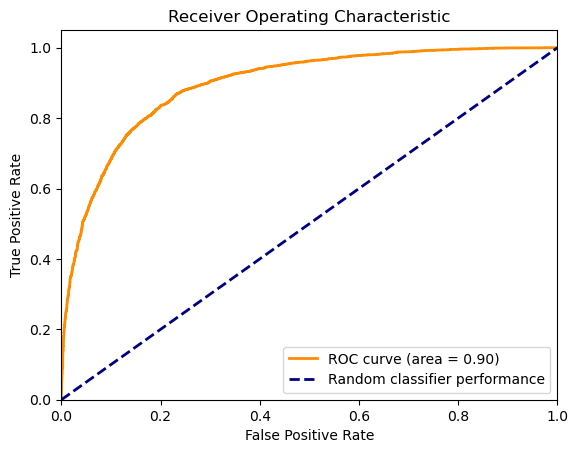

In [14]:
plot_roc_curve(y_test, y_prob)

# Сведения о модели
Для задачи бинарной классификации была использована модель **XGBoost** (Extreme Gradient Boosting) — популярная реализация метода градиентного бустинга для деревьев решений. Этот алгоритм основан на последовательном построении деревьев решений, где каждое следующее дерево пытается скорректировать ошибки, допущенные предыдущими.

# Описание эксперимента

1. Исследовательский анализ данных (EDA):
    * Проведён анализ распределения целевой переменной booking_status и отдельных признаков, таких как avg_price_per_room и arrival_date.
    * Построена корреляционная матрица для изучения взаимосвязей между признаками.

2. Предварительная обработка данных:
    * Категориальные переменные, такие как type_of_meal_plan, были закодированы с использованием one-hot encoding.
    * Числовые переменные масштабированы с помощью метода стандартизации (StandardScaler).

3. Модель:
    * Данные были разделены на обучающую (80%) и тестовую (20%) выборки.
    * Обучена модель XGBoost с метрикой logloss.
    * Проведена оценка качества модели с использованием ROC-кривой, метрик точности (precision), полноты (recall) и F1-меры.

# Результаты
1. Метрики классификации:
    * Точность (accuracy): 82.30%
    * Матрица ошибок показывает, что:
        * Из 5150 объектов класса 0 (не отменено) модель правильно классифицировала 4464 (87%).
        * Из 3270 объектов класса 1 (отменено) модель правильно классифицировала 2466 (75%).
    * Precision для класса 1 составляет 78%, что указывает на приемлемую способность модели правильно предсказывать отмены бронирования.

2. ROC-кривая:
    * Площадь под кривой (AUC): 0.90, что свидетельствует о высокой дискриминационной способности модели (отличное разделение классов).

# Выводы
* Модель XGBoost показала хорошую производительность на тестовой выборке, достигая точности 82.3% и AUC = 0.90.
* Метрики классификации демонстрируют, что модель успешно справляется с задачей предсказания отмен бронирования, хотя у класса 1 (отмены) точность несколько ниже из-за меньшей полноты (recall = 75%).
* В дальнейшем можно улучшить результат путём подбора гиперпараметров XGBoost, а также увеличения сбалансированности классов (например, с использованием oversampling или weights adjustment).